In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

## Downloading and becoming one with the data

In [24]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

## Creating data loaders (preparing the data)

Now we've downloaded the data, let's use the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class along with the `flow_from_directory` method to load in our images.

In [25]:
# Setup data inputs
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

train_datagen = ImageDataGenerator()#rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

# print(len(img))   #  (1,256,256,3)

Training images:
Found 7500 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [26]:
for img ,label in train_data:
    print(img[0])
    print(label.shape)
    break;

[[[ 72.  82.  83.]
  [ 68.  78.  79.]
  [ 65.  74.  73.]
  ...
  [107. 107. 115.]
  [105. 105. 113.]
  [103. 103. 113.]]

 [[ 67.  77.  78.]
  [ 64.  74.  75.]
  [ 73.  81.  83.]
  ...
  [104. 107. 114.]
  [105. 105. 113.]
  [102. 102. 112.]]

 [[ 69.  79.  80.]
  [ 69.  79.  80.]
  [ 76.  84.  86.]
  ...
  [109. 112. 119.]
  [107. 110. 119.]
  [105. 108. 117.]]

 ...

 [[192. 203. 209.]
  [197. 208. 212.]
  [198. 209. 213.]
  ...
  [  2.   4.   1.]
  [  1.   3.   0.]
  [  1.   3.   0.]]

 [[188. 199. 205.]
  [195. 206. 210.]
  [198. 209. 213.]
  ...
  [  2.   4.   1.]
  [  2.   4.   1.]
  [  3.   5.   2.]]

 [[185. 196. 202.]
  [193. 204. 208.]
  [197. 208. 212.]
  ...
  [  2.   4.   1.]
  [  1.   3.   0.]
  [  2.   4.   1.]]]
(32, 10)


Excellent! Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).

# Create and Fit the model


And what about a summary of our model?

You can see the power of TensorFlow Hub here. The feature extraction layer has 4,062,381 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set `trainable=False`, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 12,810 parameters in the output layer to suit our dataset.



In [29]:

from tensorflow import keras
from keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False )
base_model.trainable = False
# Input and Data Augmentation
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)

x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(.3)(x)

x = layers.Dense(train_data.num_classes)(x)
outputs = layers.Activation("softmax")(x)
efficientnet_model = tf.keras.Model(inputs, outputs)

# # Fine tuning 
# for layer in base_model.layers[:]:
#     layer.trainable = False

# for layer in base_model.layers[-20:]:
#     layer.trainable = True

# Compiling the model
efficientnet_model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["accuracy"])
efficientnet_history = efficientnet_model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data))
                    )

# Save history
import numpy as np 
np.save('history_10.npy',efficientnet_history.history)

Epoch 1/5
235/235 [==============================] - 228s 944ms/step - loss: 0.9157 - accuracy: 0.7288 - val_loss: 0.4093 - val_accuracy: 0.9062
Epoch 2/5
235/235 [==============================] - 239s 1s/step - loss: 0.5233 - accuracy: 0.8421 - val_loss: 0.3380 - val_accuracy: 0.8864
Epoch 3/5
235/235 [==============================] - 248s 1s/step - loss: 0.4524 - accuracy: 0.8575 - val_loss: 0.3172 - val_accuracy: 0.9176
Epoch 4/5
235/235 [==============================] - 240s 1s/step - loss: 0.4126 - accuracy: 0.8705 - val_loss: 0.2895 - val_accuracy: 0.9091
Epoch 5/5
235/235 [==============================] - 239s 1s/step - loss: 0.3812 - accuracy: 0.8784 - val_loss: 0.2887 - val_accuracy: 0.9233


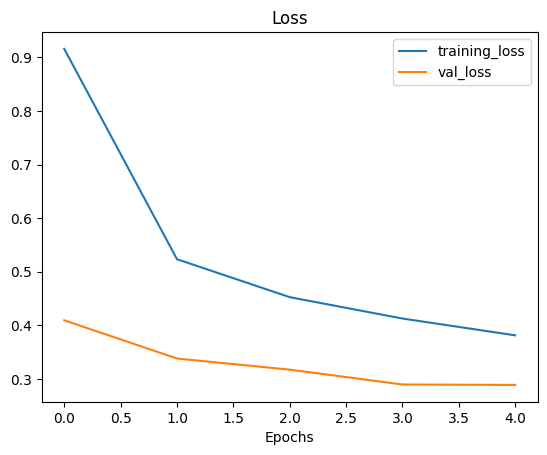

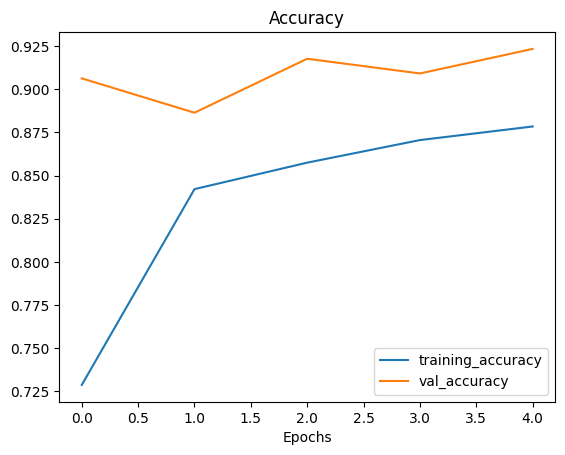

In [32]:
plot_loss_curves(efficientnet_history)

From the look of the EfficientNetB0 model's loss curves, it looks like if we kept training our model for longer, it might improve even further. Perhaps that's something you might want to try?

Let's check out the model summary.

In [20]:
efficientnet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                           

# Prediction

In [12]:

# saving and loading the .h5 model
 
# save model
efficientnet_model.save('model/efficientnet_model')
print('Model Saved!')
 


INFO:tensorflow:Assets written to: model/efficientnet_model\assets


INFO:tensorflow:Assets written to: model/efficientnet_model\assets


Model Saved!


In [13]:
# load model
savedModel=tf.keras.models.load_model('model/efficientnet_model')
savedModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
1/1 [==============================] - 0s 33ms/step


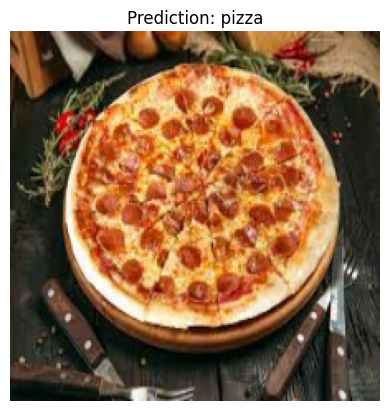

In [19]:
# Lấy label trong data
import pathlib
import numpy as np
data_dir = pathlib.Path("10_food_classes_all_data/train/") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

def load_and_prep_image(filename, img_shape=224):
  """
  Đọc hình ảnh và biến dữ liệu thành tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  
  return img
pred_and_plot(savedModel,'pizza.jpg',class_names)